# Neutrino event classification

This mini-project's dataset is comprised of a number of small files containing images of simulated neutrino interactions in a hypothetical detector that looks an awful lot like the detectors of the NOvA experiment. For each neutrino interaction the images consist of two $100 \times 80$ pixel images that represent the $x \times z$ and $y \times z$ projections of the tracks of particles in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| neutrino1.h5 | The 1st HDF5 file containing event images and meta deta |
| $\vdots$ | The middle ones |
| neutrino200.h5| The 200th HDF5 file|


The images show the energy deposited by simulated neutrinos in a NOvA like detector. Some of the meta information in the hdf5 file is described below

| Label | Description |
| ----------- | ----------- |
| neutrino/nuenergy | Neutrino Energy (GeV) |
| neutrino/lepenergy | Lepton Energy (GeV) |
| neutrino/finalstate | Interaction |
| neutrino/finalstate | Final State |
 

The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

The $interaction$ says what kind of interaction occured and is defined in the enumeration below.

## Machine learning tasks
1. Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events
2. Test your machine learning classifier and investigate how the efficiency of the classifier depends on the meta data variables shown above

### Potential extensions
1. Write a machine learning algorithm to determine the energy of the neutrino
2. Write a machine learning algorithm to determine the flavour of the neutrino
3. Write a machine learning algorithm to determine $y=$ lepton energy over neutrino energy
4. Write a machine learning algorithm to determine the number of protons or pions
5. Write a machine learning algorithm to determine the interaction mode.




In [1]:
#imports

import h5py
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import pydot
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
import enum 
class Interaction(enum.Enum):
    kNumuQE =0           # Numu CC QE interaction
    kNumuRes =1           # Numu CC Resonant interaction
    kNumuDIS = 2          # Numu CC DIS interaction
    kNumuOther = 3        # Numu CC, other than above
    kNueQE = 4            # Nue CC QE interaction
    kNueRes = 5           # Nue CC Resonant interaction
    kNueDIS = 6           # Nue CC DIS interaction
    kNueOther = 7         # Nue CC, other than above
    kNutauQE = 8          # Nutau CC QE interaction
    kNutauRes = 9         # Nutau CC Resonant interaction
    kNutauDIS =10         # Nutau CC DIS interaction
    kNutauOther =11       # Nutau CC, other than above
    kNuElectronElastic = 12# NC Nu On E Scattering
    kNC =13                # NC interaction
    kCosmic =14           # Cosmic ray background
    kOther =15            # Something else.  Tau?  Hopefully we don't use this
    kNIntType=16          # Number of interaction types, used like a vector size

    
class FinalState(enum.Enum):
    kNumu0tr0sh=0          # Numu CC - no track no shower
    kNumu0tr1sh=1          # Numu CC - no track  1 shower
    kNumu0tr2sh=enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh=enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh=enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh=enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh=enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh=enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh=enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh=enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh=enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh=enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh=enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh=enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh=enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh=enum.auto()          # Numu CC - 3+ track 3+ shower
    kNue0tr0sh=enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh=enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh=enum.auto()           # Nue CC - no track  2 showe
    kNue0trMsh=enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh=enum.auto()           # Nue CC -  1 track no shower
    kNue1tr1sh=enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh=enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh=enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh=enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh=enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh=enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh=enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh=enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh=enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh=enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh=enum.auto()           # Nue CC - 3+ track 3+ shower
    kNC0tr0sh=enum.auto()           # NC CC - no track no shower
    kNC0tr1sh=enum.auto()           # NC CC - no track  1 shower
    kNC0tr2sh=enum.auto()           # NC CC - no track  2 shower
    kNC0trMsh=enum.auto()           # NC CC - no track 3+ shower
    kNC1tr0sh=enum.auto()           # NC CC -  1 track no shower
    kNC1tr1sh=enum.auto()           # NC CC -  1 track  1 shower
    kNC1tr2sh=enum.auto()           # NC CC -  1 track  2 shower
    kNC1trMsh=enum.auto()           # NC CC -  1 track 3+ shower
    kNC2tr0sh=enum.auto()           # NC CC -  2 track no shower
    kNC2tr1sh=enum.auto()           # NC CC -  2 track  1 shower
    kNC2tr2sh=enum.auto()           # NC CC -  2 track  2 shower
    kNC2trMsh=enum.auto()           # NC CC -  2 track 3+ shower
    kNCMtr0sh=enum.auto()           # NC CC - 3+ track no shower
    kNCMtr1sh=enum.auto()           # NC CC - 3+ track  1 shower
    kNCMtr2sh=enum.auto()           # NC CC - 3+ track  2 shower
    kNCMtrMsh=enum.auto()           # NC CC - 3+ track 3+ shower
    kCosmicFS=enum.auto()           # Cosmic ray background
    kOtherFS=enum.auto()            # Something else.  Tau?  Hopefully we don't use this
    kNFStType=enum.auto()            # Number of interaction types, used like a vector size



In [3]:
# import the urllib library
import urllib.request
 
# Copy a network object to a local file
urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino1.h5', "neutrino1.h5")

#Open the local h5 file with h5py
df=h5py.File('neutrino1.h5','r')
type(df)

h5py._hl.files.File

In [4]:
#Print the keys in the neutrino meta data
print(df.keys())
print(df['neutrino'].keys())

#Get an numpy array containing the event image, and reshape it from flat to 2x100x80
print(np.shape(df['cvnmap']))
print(df['neutrino']['evt'])
event0=np.array(df['cvnmap'][3]).reshape((2,100,80))

<KeysViewHDF5 ['cvnmap', 'neutrino']>
<KeysViewHDF5 ['cycle', 'evt', 'finalstate', 'finalstateprong', 'interaction', 'lepenergy', 'nuenergy', 'parent', 'particles', 'rec.training.trainingdata_idx', 'run', 'subevt', 'subrun', 'vtxx', 'vtxy', 'vtxz']>
(7001, 16000)
<HDF5 dataset "evt": shape (7001, 1), type "<u4">


Text(0, 0.5, 'z')

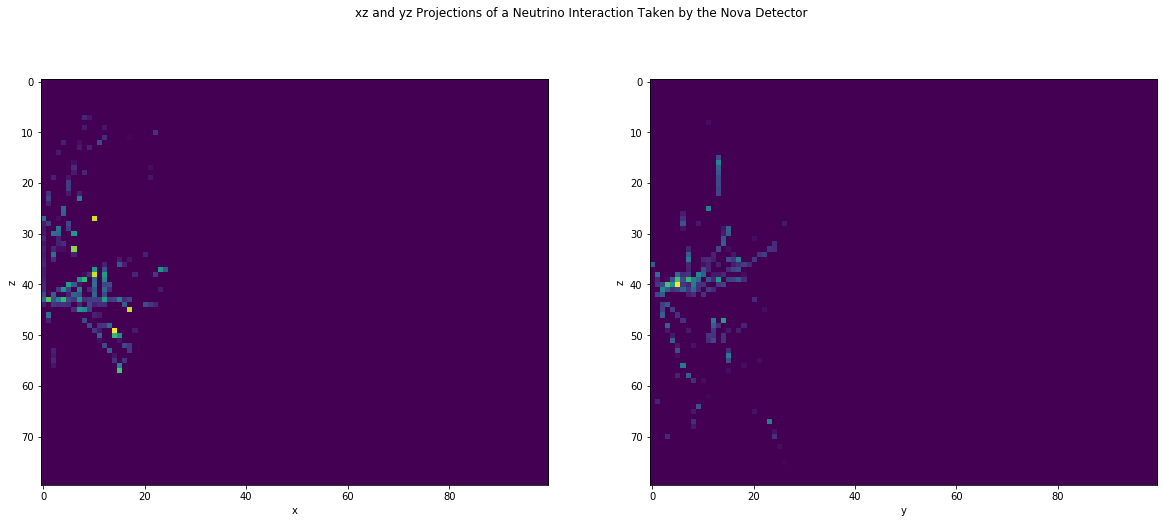

In [5]:
#Plot the first event, look it is a nice long muon track
fig, ax = plt.subplots(1,2, figsize = (20,8))
fig.suptitle('xz and yz Projections of a Neutrino Interaction Taken by the Nova Detector')
ax[0].imshow(event0[1].T)
ax[0].set_xlabel('x')
ax[0].set_ylabel('z')
ax[1].imshow(event0[0].T)
ax[1].set_xlabel('y')
ax[1].set_ylabel('z')

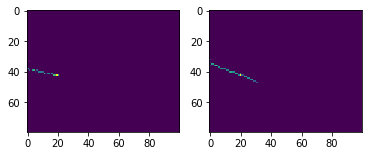

In [6]:
event1=np.array(df['cvnmap'][4]).reshape((2,100,80))
fig, ax = plt.subplots(1,2)
ax[0].imshow(event1[1].T)
ax[1].imshow(event1[0].T)

In [7]:
print("Neutrino Final State code",df['neutrino']['finalstate'][3])
print("Interaction was ",Interaction(df['neutrino']['interaction'][3]))
print("Neutrino energy",df['neutrino']['nuenergy'][3],"GeV")

Neutrino Final State code [46]
Interaction was  Interaction.kNC
Neutrino energy [13.677229] GeV


(array([3358., 1891., 1013.,  394.,  184.,   85.,   44.,   14.,    8.,
          10.]),
 array([ 0.      ,  8.229538, 16.459076, 24.688614, 32.91815 , 41.14769 ,
        49.377228, 57.606766, 65.8363  , 74.06584 , 82.29538 ],
       dtype=float32),
 <a list of 10 Patch objects>)

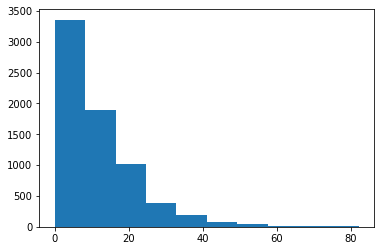

In [8]:
fs=np.array(df['neutrino']['finalstate'])
nuenergy=np.array(df['neutrino']['nuenergy'])
fig, ax = plt.subplots()
ax.hist(nuenergy)

## Preprocessing
In this section, we gather the relevant images as well as the label data which we process it into a Pandas DataFrame object. 

**Tasks** 
* Write a function which creates a Pandas DataFrame from the label data
* Write a function that collects the input images (this will be the input for the machine learning tasks). 
* Gather different files from the UCL website, apply the function defined above and concatenate to the master DataFrame.
* Normalise the image scale. 

### 1. Write a function that creates a Pandas DataFrame from the label data

In [9]:
def toDF(df): 
   
    #Get the labels or column names for our dataframe. This will always be the keys in the neutrino file. 
    labels = list(df['neutrino'].keys())
    
    
    #create a dictionary with the label names for keys and the array of the data for each column as values. 
    d = {str(label) : np.array(df['neutrino'][str(label)]).T[0] for label in labels}
    
    #convert the dictionary to a pandas dataframe. 
    df = pd.DataFrame.from_dict(d)
    
    return df

### 2. Write a function that collects the input images

In [10]:
def getX(df): 
    
    #create a numpy array from the images
    input_array = np.array(df['cvnmap'])
    
    #Now we create our input array by changing the shape of the images from flat to 2*100*80
    X = input_array.reshape(input_array.shape[0], 2,100,80)
    X1 = X[:,0].reshape(input_array.shape[0],100, 80,1)
    X2 = X[:,1].reshape(input_array.shape[0],100, 80,1)
    X = np.concatenate([X1,X2], axis=3)

    return X 
    
    
    

### 3. Gather different files from the UCL website and append them to a master DataFrame

In [11]:

#empty label df 
label_df = pd.DataFrame()

#empty input array
X = np.zeros((0, 100,80,2))

for filenum in range(1,16):
    
    #gather the different files from the UCL website
    urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino'+str(filenum)+'.h5', 'neutrino'+str(filenum)+'.h5')
    df = h5py.File('neutrino'+ str(filenum)+'.h5','r')
    
    #get the input features
    inputs = getX(df)
    X = np.concatenate([X, inputs], axis = 0)
    
    #convert the feature file into a pandas df
    df = toDF(df)
    
    #append it to the label dataframe
    label_df= label_df.append(df)
    
    print('Done: {}/15'.format(filenum))

Done: 1/15
Done: 2/15
Done: 3/15
Done: 4/15
Done: 5/15
Done: 6/15
Done: 7/15
Done: 8/15
Done: 9/15
Done: 10/15
Done: 11/15
Done: 12/15
Done: 13/15
Done: 14/15
Done: 15/15


In [12]:
label_df.head()

,cycle,evt,finalstate,finalstateprong,interaction,lepenergy,nuenergy,parent,particles,rec.training.trainingdata_idx,run,subevt,subrun,vtxx,vtxy,vtxz
0,15,1,8,1,0,32.837307,33.076805,1,23,0,12053,1,0,-76.117852,311.595491,-1757.971398
1,15,1,12,3,2,0.986411,6.852915,1,33,0,12053,2,0,376.344346,232.187717,389.125703
2,15,1,13,3,2,0.631563,1.641000,0,23,0,12053,3,0,47.172435,-161.841829,871.827338
3,15,1,46,11,13,2.768984,13.677229,4,70,0,12053,5,0,28.927787,128.163077,726.942543
4,15,1,49,13,0,1.848964,1.892379,0,270,0,12053,7,0,-158.862074,175.131230,94.934196


In [13]:
label_df.shape, X.shape

((103970, 16), (103970, 100, 80, 2))

In [14]:
np.min(X)

0.0

In [15]:
np.max(X)

255.0

In [16]:
label_df.dtypes

cycle                              int32
evt                               uint32
finalstate                        uint32
finalstateprong                   uint32
interaction                       uint32
lepenergy                        float32
nuenergy                         float32
parent                            uint32
particles                         uint32
rec.training.trainingdata_idx     uint32
run                               uint32
subevt                            uint16
subrun                            uint32
vtxx                             float64
vtxy                             float64
vtxz                             float64
dtype: object

In [17]:
X.shape

(103970, 100, 80, 2)

### 4. Normalise the images

In [18]:
maxX = np.max(X)
#maxX.shape

In [19]:
maxX

255.0

In [20]:

X = X/maxX

In [21]:
np.max(X)

1.0

## Machine Learning Tasks 
### 1. Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events

#### Sub tasks
 
* Split the data.
* Get the labels.
* Under-sample
* Split the images in the $x \times z$ and $y \times z$ components
* Build a model/ decide the architecture.
* Train the model. 
* Evaluate the model

#### Split the Data
In this section we will split the data into a training, validation and testing set. The reason for using a validation set is that will allow us to refine certain parameters of the model after training. 

In [22]:
#make the label column a numpy array
#labels = np.array(label_df)

In [23]:
#80% train, 10% validation and 10% testing
X_train, X_test, labels_train, labels_test = train_test_split(X, label_df, test_size = 0.1, shuffle = True)
X_train, X_val, labels_train, labels_val = train_test_split(X_train, labels_train, test_size = 0.11, shuffle = True)

In [24]:
y_train, y_val, y_test = np.array(labels_train.interaction), np.array(labels_val.interaction), np.array(labels_test.interaction)

In [25]:
labels_train

,cycle,evt,finalstate,finalstateprong,interaction,lepenergy,nuenergy,parent,particles,rec.training.trainingdata_idx,run,subevt,subrun,vtxx,vtxy,vtxz
4025,1,582,12,3,2,1.834962,7.578969,1,157,0,12059,5,10,400.111141,-135.756447,-475.545354
5190,1,773,13,3,2,12.448025,29.559664,1,55,0,12056,10,10,-131.747045,-213.281061,1343.745263
3751,6,531,8,1,2,0.610079,2.849688,0,173,0,12056,2,20,-71.850929,-1.264191,26.152318
5523,7,821,49,13,2,3.884383,4.671201,1,2,0,12055,2,0,57.360509,-132.987309,1041.134299
3449,3,508,12,3,1,0.309621,1.634750,0,18,0,12053,5,20,-186.104915,64.406477,970.694745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,1,188,44,11,13,5.088801,11.192234,3,30,0,12059,3,10,43.534245,-63.708240,1505.275270
6872,6,974,14,3,2,1.252180,21.979393,1,126,0,12056,6,20,-280.985260,433.067308,1232.375466
2778,1,405,13,3,2,8.590254,21.393751,1,55,0,12074,1,10,-66.549010,56.440002,330.083012
1820,1,261,4,1,2,8.487636,10.004232,1,8,0,12056,1,21,-1.823253,45.323778,-1373.998144


(array([3188., 5680.,  310.,   22.,   80.,    0.,    0.,    0., 1030.,
          87.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

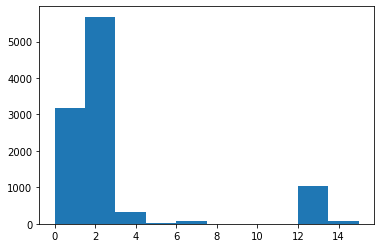

In [26]:
plt.hist(y_test)

#### Get the labels

For this task, we're only interested in identifying $\mu_\nu $ charged-current events in general and there are 3 different types of $\mu_\nu $ charged-current events. These correspond to values ```0,1,2,3``` in the ```interaction``` column. Since this is a binary classification task, we need to create a label array containing only 1s and 0s. In mathematical notation, we can write the function which maps the elements from ```interaction ```to the label array: $$\forall x \in S, y: S \to \{0,1\}: \begin{cases} y(x) = 1, \mbox{ if } x \leq 3 \\ y(x) = 0, \mbox{ if } x > 3 \end{cases} $$

In [27]:
def To0_1(array):
    
    '''This function takes the label array and converts it into an array containing 0's and 1's
    it will mostly be used for the first task'''
    
    #ge the indices corresponding to nu mu cc events
    labels_idx = np.where(array <= 3)
    
    #all the values <= 3 become 1 and the rest become 0
    y = np.zeros(len(array))
    y[labels_idx]= 1
    y.astype(int)
    
    return y 

In [28]:
y1_train, y1_val, y1_test = To0_1(y_train), To0_1(y_val), To0_1(y_test)

In [29]:
np.min(y1_train), np.max(y1_train)

(0.0, 1.0)

In [30]:
X_train.shape, y1_train.shape, X_val.shape, y1_val.shape, X_test.shape, y1_test.shape

((83279, 100, 80, 2),
 (83279,),
 (10294, 100, 80, 2),
 (10294,),
 (10397, 100, 80, 2),
 (10397,))

Now, let's analyse the label data to look at the class distribution:

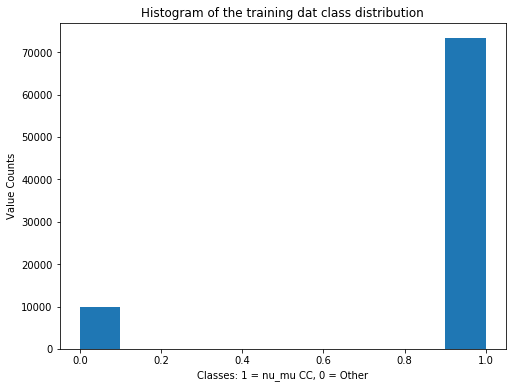

In [31]:
plt.figure(figsize = (8,6))
plt.hist(y1_train)
plt.title('Histogram of the training dat class distribution');
plt.xlabel('Classes: 1 = nu_mu CC, 0 = Other');
plt.ylabel('Value Counts');

We can notice that our classes imbalanced, with about 88% of all our observations representing $\nu_{\mu}$ charged-current events. This could lead to our model ignoring one class and classifying all images into one category to maximise the accuracy.

#### Under-Sample
Since we have a lot of data available, we can under-sample the training data to train the model on a balanced dataset. This should produce better results during the validation and testing phase. 

In [32]:
def UnderSamplingIdx(data):
    '''This function returns a list of random indices corresponding to the majority class in the data
    which has the length of the amount of observations in the minority class. '''
    
    majority_indices = np.where(data ==1)[0]
    minority_indices = np.where(data == 0)[0]
    
    random_majority_indices = np.random.choice(majority_indices,len(minority_indices), replace = False )
    
    under_sampling_indices = np.concatenate([random_majority_indices, minority_indices])
    
    return under_sampling_indices
    

In [33]:
#under sample to the training data
under_sampling_indices = UnderSamplingIdx(y1_train)
y1_train = y1_train[under_sampling_indices]
X_train = X_train[under_sampling_indices]

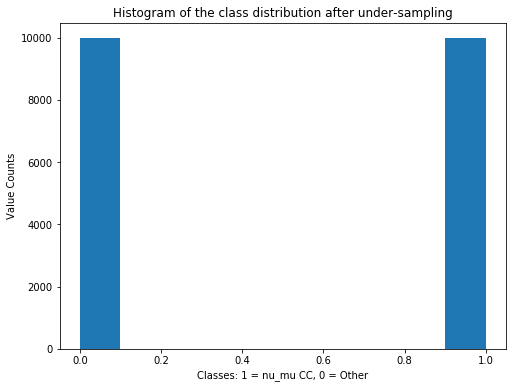

In [34]:
#plot the class distribution of the images to see if the under sampling worked
plt.figure(figsize = (8,6))
plt.hist(y1_train)
plt.title('Histogram of the class distribution after under-sampling');
plt.xlabel('Classes: 1 = nu_mu CC, 0 = Other');
plt.ylabel('Value Counts');

#### Split the images into $x \times z$ and $y \times z$ components

In [35]:
def ImageSplit(images, n_images):
    
    ''' This function splits a doublet of images into one projection on the xz axis and one projection
    on the yz axis'''
    images = images.reshape(n_images, 2,100,80)
    XZ  = images[:,0].reshape(n_images, 100,80,1)
    YZ  = images[:,1].reshape(n_images, 100,80,1)
    
    return XZ,YZ

In [36]:
#split the training images
n_training_images = y1_train.shape[0]
print(X_train.shape, y1_train.shape[0])
XZ_train = ImageSplit(X_train, n_training_images )[0]
YZ_train = ImageSplit(X_train, n_training_images)[1]
XZ_train.shape,YZ_train.shape

(19964, 100, 80, 2) 19964


((19964, 100, 80, 1), (19964, 100, 80, 1))

In [37]:
#split the testing images
n_testing_images = y1_test.shape[0]
XZ_test = ImageSplit(X_test, n_testing_images)[0]
YZ_test = ImageSplit(X_test, n_testing_images)[1]
XZ_test.shape,YZ_test.shape

((10397, 100, 80, 1), (10397, 100, 80, 1))

In [38]:
#split the validation images
n_val_images = y1_val.shape[0]
XZ_val = ImageSplit(X_val, n_val_images)[0]
YZ_val = ImageSplit(X_val, n_val_images)[1]
XZ_test.shape,YZ_test.shape

((10397, 100, 80, 1), (10397, 100, 80, 1))

#### Build a model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xz_img (InputLayer)             [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
yz_img (InputLayer)             [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 8)   208         xz_img[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 80, 8)   208         yz_img[0][0]                     
______________________________________________________________________________________________

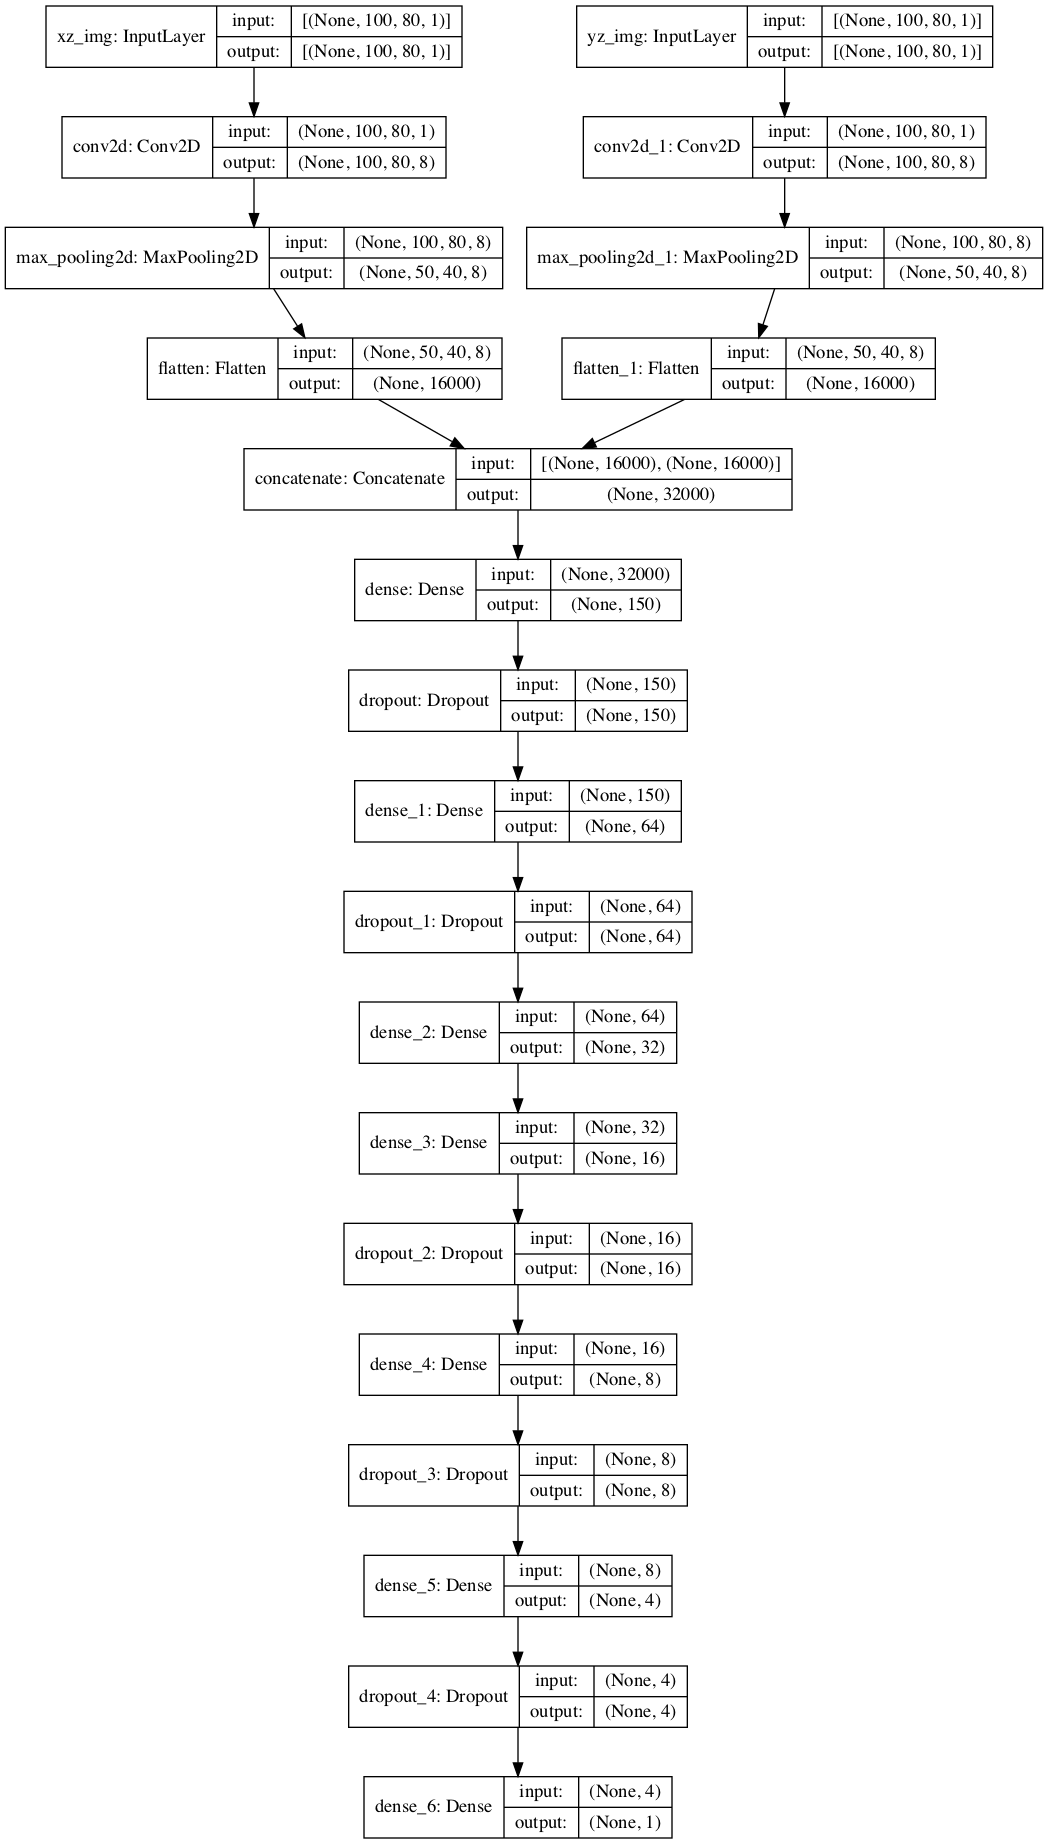

In [39]:

#2 different inputs, one for each image
XZ_input = keras.Input( shape = (100,80,1), name = 'xz_img')
YZ_input = keras.Input( shape = (100,80,1), name = 'yz_img')

#1 convolution and 1 maxpooling for each image
xz = layers.Conv2D(8, (5,5), activation = 'relu', padding ='same')(XZ_input)
xz = layers.MaxPooling2D((2,2))(xz)

yz = layers.Conv2D(8, (5,5), activation = 'relu', padding = 'same')(YZ_input)
yz = layers.MaxPooling2D((2,2))(yz)

#flatten 
xz = layers.Flatten()(xz)

yz = layers.Flatten()(yz)

#Concatenate the two vectors and add some dense layers with dropouts to fight overfitting
x = layers.concatenate([xz,yz])
x = layers.Dense(150, activation = 'relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(16, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(8, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(4, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)

#output layer with one node and a sigmoid activation to map every number to 0,1
pred = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs=[XZ_input, YZ_input],outputs=[pred])
model.summary()
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [40]:
#compile with adam optimiser, cross entropy loss
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
          metrics=tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5))

In [41]:
#Create a Checkpoint for the model
filepath = 'numu_classifier.hdf5' #store the model in the ipynb directory

#Save the version of the model with the lowest validation loss over all epochs. 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]

In [42]:
#fit the model, 16 epochs, 500 batch_size evaluate on the validation data and create a checkpoint for the best epoch.
history = model.fit({'xz_img': XZ_train, 'yz_img': YZ_train},y1_train, 
                    epochs = 16, batch_size = 500, validation_data = ([XZ_val, YZ_val], y1_val), 
                    verbose = 1, callbacks = callbacks_list )

Epoch 1/16
40/40 [==============================] - 100s 2s/step - loss: 0.6767 - binary_accuracy: 0.5616 - val_loss: 0.5844 - val_binary_accuracy: 0.4732
Epoch 2/16
40/40 [==============================] - 94s 2s/step - loss: 0.6478 - binary_accuracy: 0.6349 - val_loss: 0.5379 - val_binary_accuracy: 0.5357
Epoch 3/16
40/40 [==============================] - 92s 2s/step - loss: 0.6183 - binary_accuracy: 0.6694 - val_loss: 0.5248 - val_binary_accuracy: 0.5126
Epoch 4/16
40/40 [==============================] - 90s 2s/step - loss: 0.5852 - binary_accuracy: 0.6970 - val_loss: 0.4893 - val_binary_accuracy: 0.5593
Epoch 5/16
40/40 [==============================] - 90s 2s/step - loss: 0.5575 - binary_accuracy: 0.7162 - val_loss: 0.4502 - val_binary_accuracy: 0.6448
Epoch 6/16
40/40 [==============================] - 90s 2s/step - loss: 0.5372 - binary_accuracy: 0.7321 - val_loss: 0.5598 - val_binary_accuracy: 0.5327
Epoch 7/16
40/40 [==============================] - 90s 2s/step - loss: 0.5

In [43]:
#load the saved model with the lowest validation loss
model = keras.models.load_model('numu_classifier.hdf5')

In [44]:
model.evaluate([XZ_val, YZ_val], y1_val)[0]

322/322 [==============================] - 17s 52ms/step - loss: 0.4237 - binary_accuracy: 0.7420


0.4237081706523895

### 2. Test your machine learning classifier and investigate how the efficiency of the classifier depends on the meta data variables shown above
In this section we will test the classifier and see if it can be fine tuned by optimising certain parameters. Then we will investigate how its efficiency depends on some of the meta data variables. 

#### Sub Tasks 
**(a) Testing the Model** 
* Model Accuracy Curve
* Confusion Matrix 
* Matthews Correlation Coefficient
* Threshold Optimisation 

**(b) Investigating the efficiency as a function of the meta data**

* Efficiency for different types of $\nu_{\mu}$ charged-current events.
* Efficiency for different nuon and lepton energies


**(a) Testing the Model** 

**Accuracy and Loss Curve** 

In [45]:
#evaluate the model on the testing data 
model.evaluate([XZ_test, YZ_test], y1_test)

325/325 [==============================] - 17s 51ms/step - loss: 0.4429 - binary_accuracy: 0.7362


[0.4429439306259155, 0.7361738681793213]

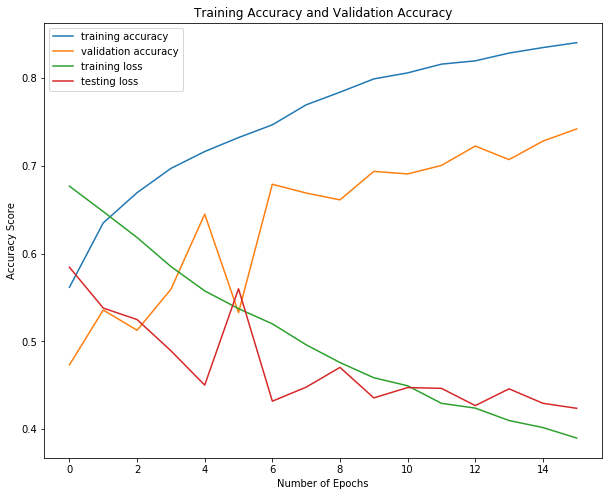

In [46]:
#plot the loss and accuracy based on the number of epochs

training_accuracy = history.history['binary_accuracy']
training_loss = history.history['loss']
val_accuracy = history.history['val_binary_accuracy']
val_loss = history.history['val_loss']


plt.figure(figsize = (10,8))
plt.plot(training_accuracy, label = 'training accuracy')
plt.plot(val_accuracy, label = 'validation accuracy')
plt.plot(training_loss, label= 'training loss')
plt.plot(val_loss, label = 'testing loss')
plt.title('Training Accuracy and Validation Accuracy')
plt.ylabel('Accuracy Score')
plt.xlabel('Number of Epochs')
plt.legend();

We see that the training binary accuracy increases steadily. The training loss is also decreasing. The validation binary accuracy increases but seems to converge to $\approx 75 \%$. The validation loss also seems to converge towards the end. 

**Confusion Matrix** 

The confusion matrix is a great metric for evaluating binary classifiers as it allows us to know the proportion of correct predictions and lets us see the amount of Type I and Type 2 errors the model has made. 

In [47]:
#round the predicted validation values (>0.5 =1, <0.5 =0)
pred = model.predict([XZ_val, YZ_val]).round()

In [121]:
def contingency_table(y_true, y_pred, color_map, ax):
    
    #create the confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    
    
    group_names = ['True Negative','Type I Error','Type II Error','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cnf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap= color_map, ax = ax);
    

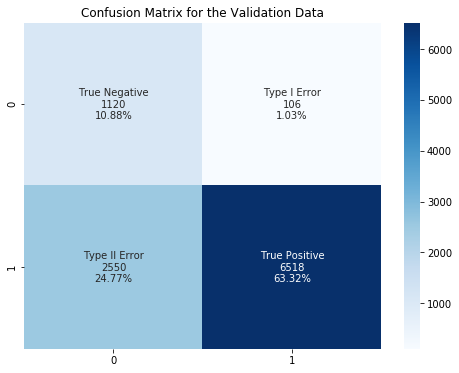

In [122]:
fig, ax = plt.subplots(figsize = (8,6))
contingency_table(y1_val, pred, color_map = 'Blues', ax = ax);
ax.set_title('Confusion Matrix for the Validation Data');

From the confusion matrix, we see that our model has a high false negative rate of $\approx 25\%$. However, it has a high true positive rate and a low type I error rate. 

**Matthews Correlation Coefficient** 

This is another metric which can be used to evaluate a binary classifier. It is particularly well suited for imbalanced data, which is the case in our validation set. The formula for the Matthews Correlation Coefficient or MCC is: $$MCC = \frac{TP \times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}} $$

TP: true positives, TN: true negatives, FP: false positives, FN: false negatives. 
Its value lies between -1 and 1. A value close to 1 indicates that there is a strong positive correlation between our predicted values and the actual values. A value close to 0 suggests that the model is no better than flipping a coin. 

The advantages of the Matthews correlation coefficient (MCC) over F1 score and accuracy in binary classification evaluation

In [51]:
#print 3 metrics: F1 score, accuracy and MCC
print('Accuracy: {0:.2f}'.format(accuracy_score(y1_val, pred)))
print('F1 Score: {0:.2f}'.format(f1_score(y1_val, pred)))
print('MCC: {0:.2f}'.format(matthews_corrcoef(y1_val, pred)))

Accuracy: 0.74
F1 Score: 0.83
MCC: 0.43


We see that the accuracy and F1 score give good results but our MCC value is quite average. Indicating the model's struggle to identify the non $\nu_{\mu}$ charged-current events. 

**Threshold Optimisation** 

We can try seeing if varying the probability threshold on the validation data yields better results on the testing data. Note: it is important to not optimise the threshold on the testing data as this would be like cheating! 

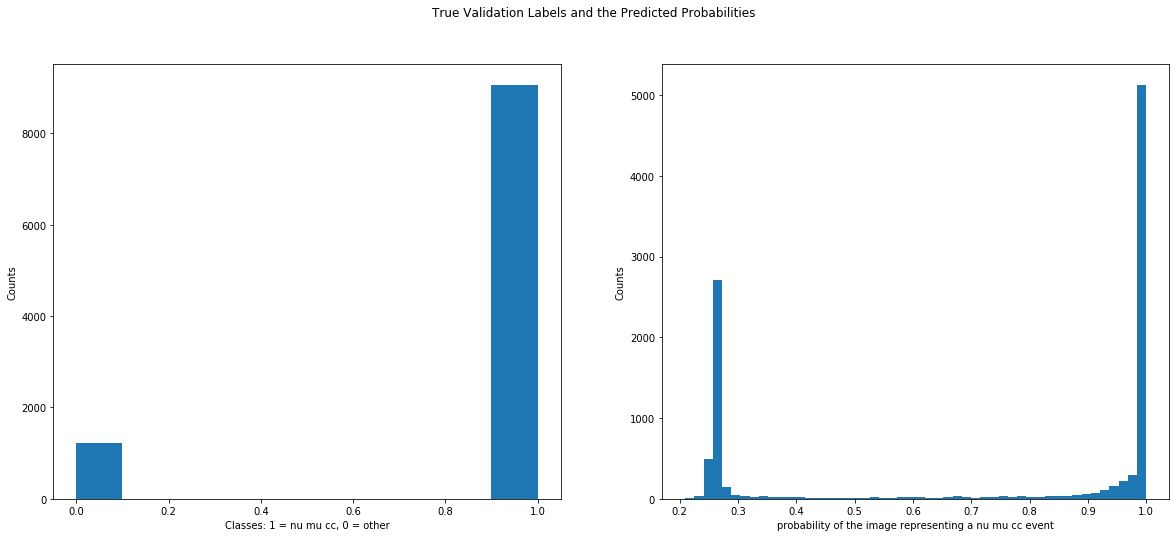

In [141]:
#plot the true labels and the predicted probabilities for the validation data.

fig,(ax1, ax2) = plt.subplots(1,2, figsize= (20,8))
fig.suptitle('True Validation Labels and the Predicted Probabilities')
ax1.hist(y1_val);
ax1.set_xlabel('Classes: 1 = nu mu cc, 0 = other')
ax1.set_ylabel('Counts');
ax2.hist(model.predict([XZ_val, YZ_val]), bins =50);
ax2.set_xlabel('probability of the image representing a nu mu cc event');
ax2.set_ylabel('Counts');

In [123]:
#create an array of thresholds between 0 and 1 to test
thresholds = np.linspace(0, 1, 100)

For this task, it is important to have a balanced dataset. Otherwise, since the validation data is highly imbalanced, the model will achieve an accuracy close to $90\%$ by setting the threshold close to $0$. We can also evaluate the variation in the MCC score for the **non under-sampled** validation data.  

In [124]:
#undersample the validation data
yunder_val = y1_val[UnderSamplingIdx(y1_val)]
XZunder_val = XZ_val[UnderSamplingIdx(y1_val)]
YZunder_val = YZ_val[UnderSamplingIdx(y1_val)]

In [125]:
#predict values for the undersampled validation set
val1_pred = model.predict([XZunder_val, YZunder_val])
val2_pred = model.predict([XZ_val, YZ_val])

In [126]:
#create an empty list
thresh_accuracies = []
MCCs = []

for threshold in thresholds: 
    #for each threshold value, round the predicted values based on the threshold
    val_pred = np.where( val1_pred > threshold, 1, 0)
    
    #evaluate the model's accuracy for each threshold and store it into the list 
    accuracy = accuracy_score(yunder_val, val_pred)
    thresh_accuracies.append(accuracy)
    
    
    #round the non undersampled predictions 
    val_pred= np.where(val2_pred > threshold, 1,0)
    
    #evaluate the MCC for these predictions
    MCC = matthews_corrcoef(y1_val, val_pred)
    MCCs.append(MCC)

    

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


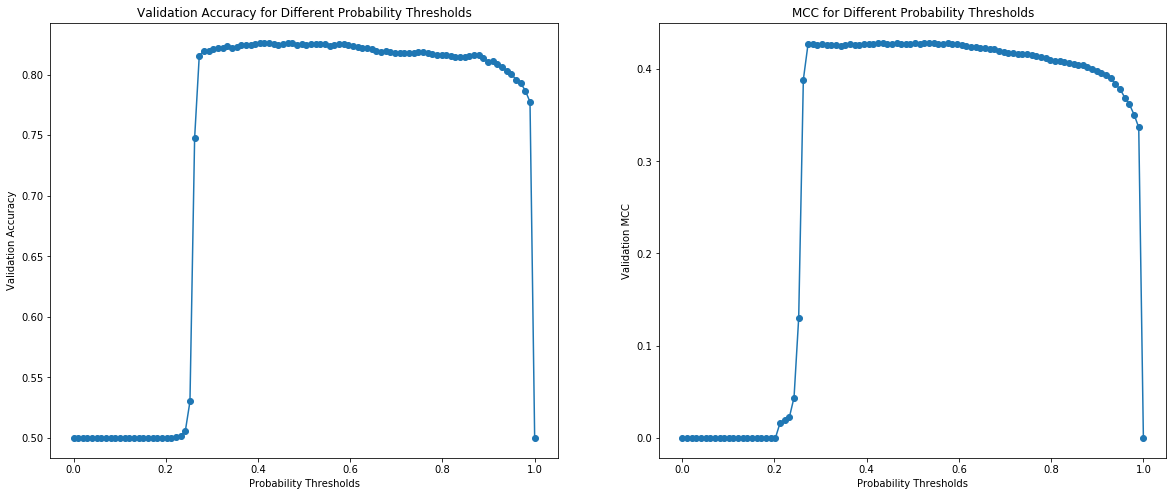

In [127]:
#plot the variation of the accuracy as a function of the probability threshold. 
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))

ax1.plot(thresholds,thresh_accuracies, '-o');
ax1.set_title('Validation Accuracy for Different Probability Thresholds');
ax1.set_xlabel('Probability Thresholds');
ax1.set_ylabel('Validation Accuracy');


ax2.plot(thresholds,MCCs, '-o');
ax2.set_title('MCC for Different Probability Thresholds');
ax2.set_xlabel('Probability Thresholds');
ax2.set_ylabel('Validation MCC');

In [128]:
#find the best threshold
thresholds[np.argmax(thresh_accuracies)], thresholds[np.argmax(MCCs)]

(0.42424242424242425, 0.42424242424242425)

In [130]:
best_threshold = thresholds[np.argmax(thresh_accuracies)]

We see that both methods return somewhat the same value for the 'optimal threshold'. It seems as though a lower probability threshold is better suited for this task. We can setting this threshold for the testing data and see how our evaluation metrics evolve. 

In [132]:
test_pred = model.predict([XZ_test, YZ_test])
test_pred = np.where(test_pred > best_threshold, 1,0)

In [133]:
accuracy_score(y1_test, test_pred)

0.7411753390401077

In [134]:
matthews_corrcoef(y1_test, test_pred)

0.4166115476111613

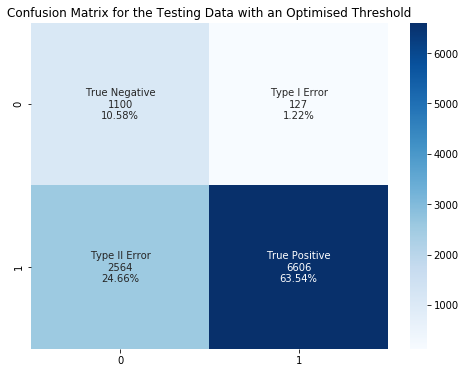

In [136]:
fig, ax = plt.subplots(figsize = (8,6))
contingency_table(y1_test, test_pred, color_map = 'Blues', ax = ax);
ax.set_title('Confusion Matrix for the Testing Data with an Optimised Threshold');

Sadly, setting the threshold to this particular value has not led to any significant improvements the predictions for the testing data. 

**(b) Investigating the Efficiency as a Function of the Metadata**

**Types of $\nu_{\mu}$ Charged-Current Events**

In this section, we will assess the performance of the classifier for the different $\nu_{\mu}$ charged-current events. 

In [64]:
def CreateLabelArr(labels,XZ, YZ, levels, interaction_types):
    
    ''' This function takes the label data from the testing set, the input images from the testing set
    a list of levels and a list of interaction types. For each level it trims the label data and the image 
    data by getting rid of all the other nu mu cc interactions. This is because we trained our model to recognise 
    these interactions in general so we don't want to tell it to classify them as negative, we're just testing its
    accuracy for different types of nu mu cc interactions. 
    
    It then creates a 1-0 label array containing based on the level. The output is a dictionnary of the testing
    images for each level, the labels for each level and the interaction types. ''' 
    
    inputs = []
    outputs = []
    for level in levels:
        
        
        #indices of the observations we want to keep (remove all other nu mu cc events)
        keep_idx = np.where((labels ==level)| (labels > 3))[0]
        label_type = labels[keep_idx]
        
        #indices of the particular type of nu mu cc event 
        ones_idx = np.where(label_type == level)
        
        #create an empty array and replace the corresponding entries with 1s
        classif_array = np.zeros(keep_idx.shape[0])
        classif_array[ones_idx] = 1
        outputs.append(classif_array)
        
        #print the shape for sanity checks
        print(classif_array.shape)

        
        #trim the input images
        inputs.append([XZ[keep_idx],YZ[keep_idx]])
        
        #create the dictionary
        dic = { 'interaction_types': interaction_types , 'inputs':inputs, 'outputs': outputs}
    
    return dic

In [65]:
data = CreateLabelArr(y_test, XZ_test, YZ_test, levels = [0,1,2,3], 
                      interaction_types= ['QE', 'RES', 'DIS', 'Other'])

(2541,)
(3101,)
(6907,)
(1529,)


In [66]:
accuracies, predictions, MCC = [],[],[]

for i in range(0,4):
    accuracies.append(model.evaluate(data['inputs'][i], data['outputs'][i])[1])
    predictions.append(model.predict(data['inputs'][i]))
    MCC.append(matthews_corrcoef(data['outputs'][i], predictions[i].round()))
    

48/48 [==============================] - 3s 53ms/step - loss: 0.6595 - binary_accuracy: 0.8934


In [67]:
for i in range(0,4):
    print(data['interaction_types'][i] + '- Testing accuracy: {0:.2f}% \n - MCC: {1:.2f}'.format(accuracies[i]*100, 
                                                    MCC[i]))

QE- Testing accuracy: 87.64% 
 - MCC: 0.75
RES- Testing accuracy: 80.46% 
 - MCC: 0.63
DIS- Testing accuracy: 71.01% 
 - MCC: 0.44
Other- Testing accuracy: 89.34% 
 - MCC: 0.69


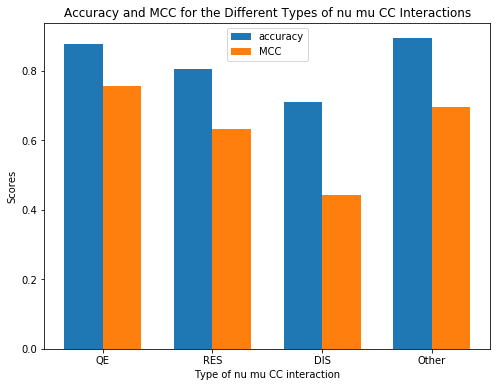

In [68]:
#plot a double bar chart of the accuracy and MCC for each type of nu mu charged-current event
x = np.arange(len(data['interaction_types']))
w = 0.35
plt.figure(figsize = (8,6));
plt.bar(x - w/2, accuracies, w, label='accuracy');
plt.bar(x + w/2, MCC, w, label='MCC');

plt.ylabel('Scores');
plt.title('Accuracy and MCC for the Different Types of nu mu CC Interactions');
plt.xticks(x, data['interaction_types']);
plt.xlabel('Type of nu mu CC interaction');
plt.legend();

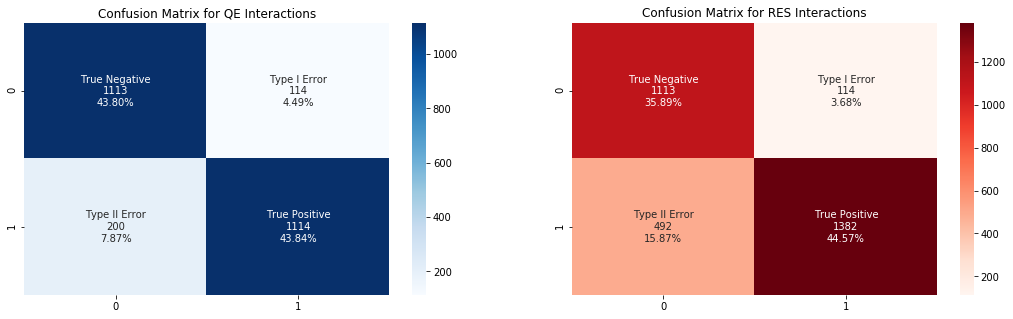

In [137]:
#plot confusion matrices for each different interaction
color_maps1 = ['Blues', 'Reds'] #'Greens', 'Oranges']
labels1 = data['outputs'][:2]
preds1 = predictions[:2]
fig, axs = plt.subplots(1,2, figsize = (18,5))
for i, (ax, color_map) in enumerate(zip(axs, color_maps1)):
    contingency_table(labels1[i], preds1[i].round(), color_map=color_map, ax=ax)
    ax.set_title('Confusion Matrix for {} Interactions'.format(data['interaction_types'][i]))

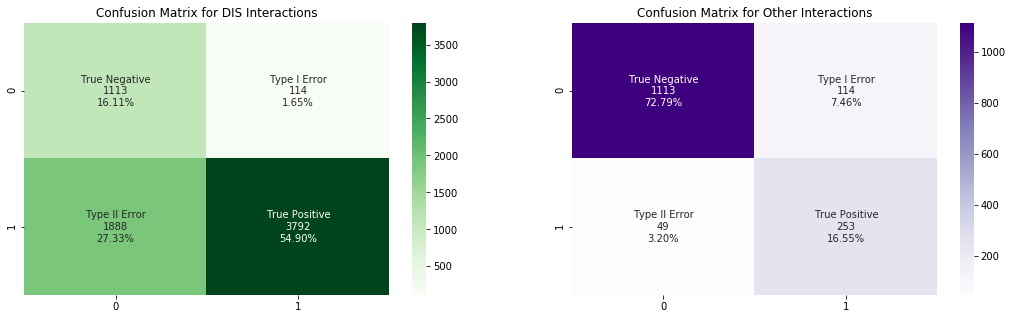

In [138]:
color_maps2 = ['Greens', 'Purples']
labels2 = data['outputs'][2:]
preds2 = predictions[2:]
fig, axs = plt.subplots(1,2, figsize = (18,5))
for i, (ax, color_map) in enumerate(zip(axs, color_maps2)):
    contingency_table(labels2[i], preds2[i].round(), color_map=color_map, ax=ax)
    ax.set_title('Confusion Matrix for {} Interactions'.format(data['interaction_types'][2:][i]))

We see that overall, the model is highly effective at identifying the Quasi-Elastic (QE) $\nu_{\mu}$ charged-current events. Its accuracy is the highest and the classifier gets almost every image right! 

**Efficiency as a Function of Neutrino and Lepton Energies** 

We can split the energies into bins and evaluate the model for images corresponding to each energy level. 

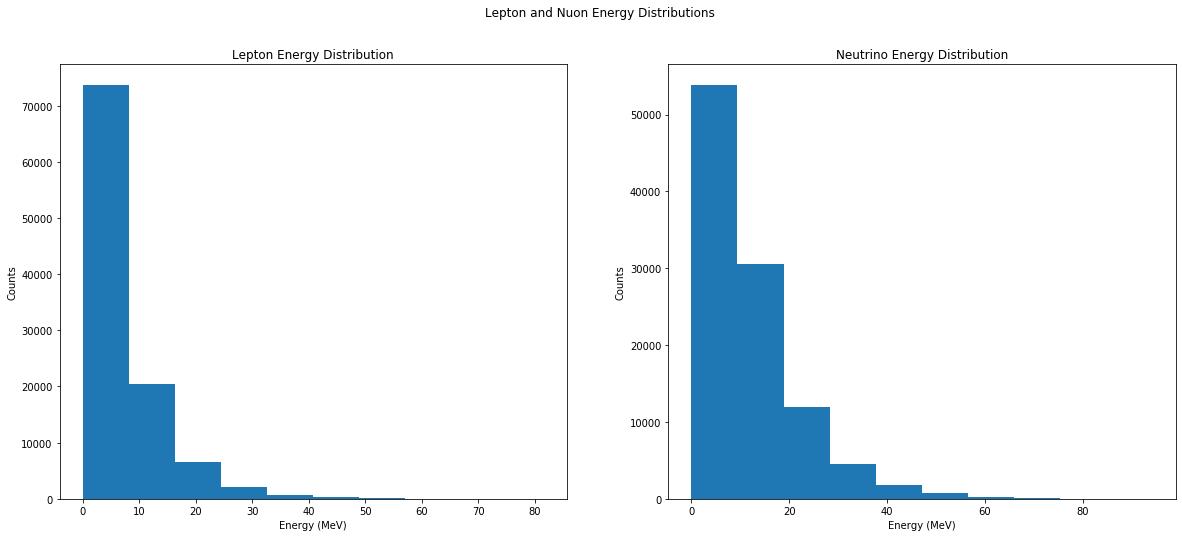

In [83]:
#plot the neutrino and lepton energy distributions

fig,(ax1, ax2) = plt.subplots(1,2, figsize= (20,8))
fig.suptitle('Lepton and Nuon Energy Distributions')
ax1.hist(label_df.lepenergy);
ax1.set_title('Lepton Energy Distribution');
ax1.set_xlabel('Energy (MeV)');
ax1.set_ylabel('Counts')
ax2.hist(label_df.nuenergy);
ax2.set_title('Neutrino Energy Distribution');
ax2.set_xlabel('Energy (MeV)');
ax2.set_ylabel('Counts');

We can see that the energy distributions for the leptons and nuons are heavily skewed to the right. Data for higher energy values is scarce so for this task, it could make sense to evaluate the performance of the model on both the validation and testing sets at the same time to have as much data as possible. 

In [72]:
#Get the energy arrays from the test set

#concat the training and validation data together
nuenergy = np.concatenate((np.array(labels_test.nuenergy), np.array(labels_val.nuenergy)))
lepenergy = np.concatenate((np.array(labels_test.lepenergy), np.array(labels_val.lepenergy)))

#check shapes
nuenergy.shape, lepenergy.shape

((20691,), (20691,))

In [73]:
def bin_energy(energies, width):
    '''This function takes an energy array and splits it into bins of arbitrary widths'''
    
    return np.digitize(energies, np.arange(np.min(energies), np.max(energies), width))*width


def energy_test_data(y, XZ, YZ, energies):
    ''' This function takes an input y (which comprises 0s and 1s), the XZ and YZ images
    and a binned energy array. It returns a dictionary containing the a list of doublets of 
    images belonging to each energy level and a set of labels (0s and 1s) for each energy level.'''
    
    
    #empty lists 
    images = []
    labels = []
    
    #iterate through each energy level
    for energy_bin in np.unique(energies):
       
        #index of observations corresponding to each energy level
        idx = np.where(energies == energy_bin)[0]
        
        #Input images for each energy level
        images.append([XZ[idx], YZ[idx]])
        
        #labels for each energy level
        labels.append(y[idx])
        
        print(y[idx].shape)
    return {'images': images, 'labels': labels, 'energy': energies}
        
        

In [74]:
nuenergy_test_data = energy_test_data(np.concatenate((y1_test, y1_val)), 
                                    #split the energies into bins of 20 MeV
                    np.concatenate((XZ_test, XZ_val)),np.concatenate((YZ_test, YZ_val)), bin_energy(nuenergy, 20))

lepenergy_test_data = energy_test_data(np.concatenate((y1_test, y1_val)), 
                                    #split the energies into bins of 20 MeV
                    np.concatenate((XZ_test, XZ_val)),np.concatenate((YZ_test, YZ_val)), bin_energy(lepenergy, 20))

(17181,)
(3050,)
(408,)
(50,)
(2,)
(19519,)
(1071,)
(95,)
(6,)


In [75]:
nu_accuracies, lep_accuracies, nu_predictions, lep_predictions, nu_MCC, lep_MCC = [], [], [], [], [], []

for i in range(0,4):
    
    #lepton energy performance metrics
    lep_accuracies.append(model.evaluate(lepenergy_test_data['images'][i], lepenergy_test_data['labels'][i])[1])
    lep_predictions.append(model.predict(lepenergy_test_data['images'][i]))
    lep_MCC.append(matthews_corrcoef(lepenergy_test_data['labels'][i], lep_predictions[i].round()))
    
    #neutrino energy performance metrics
    nu_accuracies.append(model.evaluate(nuenergy_test_data['images'][i], nuenergy_test_data['labels'][i])[1])
    nu_predictions.append(model.predict(nuenergy_test_data['images'][i]))
    nu_MCC.append(matthews_corrcoef(nuenergy_test_data['labels'][i], nu_predictions[i].round()))


    

2/2 [==============================] - 0s 39ms/step - loss: 0.3857 - binary_accuracy: 0.8800


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


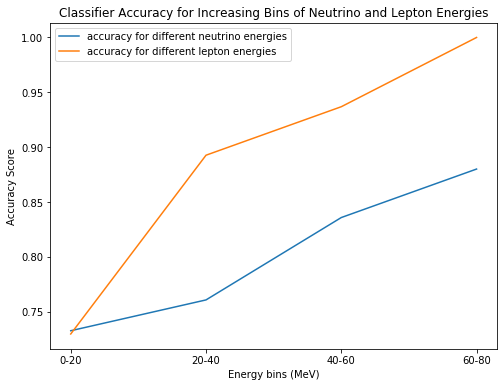

In [114]:
#plot the model's accuracy for different neutrino and lepton energies.

plt.figure(figsize = (8,6))
plt.plot(nu_accuracies, label = 'accuracy for different neutrino energies');
plt.plot(lep_accuracies, label = 'accuracy for different lepton energies');
plt.legend();
plt.ylabel('Accuracy Score');
plt.xlabel('Energy bins (MeV)');
plt.xticks([0,1,2,3],['0-20', '20-40', '40-60', '60-80']);
plt.title('Classifier Accuracy for Increasing Bins of Neutrino and Lepton Energies');

Overall, it seems as though the classifier's accuracy increases with both the neutrino and lepton energies. However, these results could be skewed by the fact that there are very few images corresponding to the higher energy bands.